<center>IE 7300: Statistical Learning for Engineering</center>

### <center>HW 5</center>
<center>Youyu Zhang</center>
<center>zhang.youy@northeastern.edu</center>
<center>(530)574-2826</center>
<center>Submitted by 10/18/2022</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#### Create a custom decision tree model using the house pricing dataset(Used in the homework 3) (18 points)

 a) Split the dataset into training and test dataset 80:20

In [2]:
# (a) Split dataset
df = pd.read_csv('houseprices.csv')
df1, df2 = np.split(df,[int(0.8*len(df))])

print(f"Original dataset length = {len(df)}")
print(f"Separated dataset lengths are"
      f"{len(df1)} and {len(df2)}")

def datacleaning(df):
    """
    This data cleaning method is going to convert categorical
    data into numerical values. 
    """
    # drop rows with null values
    df_clean = df.dropna(axis=0)
    # separate target values and predictor variables
    y = df_clean['Price']
    # Remove price from training dataset
    # Remove non-relative column "Home"
    x = df_clean.drop(columns=['Price','Home'], axis=1)
    # Convert categorical values into numerical ones
    x['Brick'] = np.where(x['Brick']=='No', 0, x['Brick'])
    x['Brick'] = np.where(x['Brick']=='Yes', 1, x['Brick'])
    x['Neighborhood'] = np.where(x['Neighborhood']=='East', 0, x['Neighborhood'])
    x['Neighborhood'] = np.where(x['Neighborhood']=='North', 1, x['Neighborhood'])
    x['Neighborhood'] = np.where(x['Neighborhood']=='West', 2, x['Neighborhood'])
    # Scaling
    x = (x-x.mean())/np.std(x)
    return x, y

# Split train dataset x and y, test dataset x_test and y_test
x_all,y_all = datacleaning(df)
x_train, x_test = np.split(x_all,[int(0.8*len(x_all))])
y_train, y_test = np.split(y_all,[int(0.8*len(y_all))])

df.head()

Original dataset length = 128
Separated dataset lengths are102 and 26


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


 b) Create a decision tree model for classification and prediction in python class format. Fit the model using training dataset. Show the model and provide proper interpretation on each node split.


In [3]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value


In [115]:
class DecisionTree():
    """
    This class includes two different decision tree method:
    1. regressor, methodName 
    2. classification, methodName_
    """
    def __init__(self, min_samples_split=2, max_depth=2):
        # initialize the root of the tree 
        self.root = None
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):  
        """
        Regressor build
        """
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

    def build_tree_(self, dataset, curr_depth=0):
        """
        Classification build
        """
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split_(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree_(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree_(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value_(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def get_best_split_(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value_(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root
        if tree.value is not None:
            print(tree.value)
        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        """
        Fit for regression.
        """
        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.concatenate((X,np.array(Y).reshape(len(Y),1)),axis=1)
        self.root = self.build_tree(dataset)
        
    def fit_(self, X, Y):
        """
        Fit for classification.
        """
        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.concatenate((X,np.array(Y).reshape(len(Y),1)),axis=1)
        self.root = self.build_tree_(dataset)

    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X): 
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

 c) Predict the house prices using the test dataset, and provide the performance metrics. Compare your output with homework 3 output.

In [5]:
regressor = DecisionTree(min_samples_split=2, max_depth=4)
regressor.fit(x_train,y_train)
regressor.print_tree()
y_pred_dr = regressor.predict(np.array(x_test))
pd.DataFrame({'Test':y_test,'Predict':y_pred_dr})

X_5 <= 0.05796087030059366 ? 360695889.1589996
 left:X_0 <= 0.04300233786187131 ? 120122419.26561213
  left:X_3 <= -0.5427694407443148 ? 77220156.25
    left:X_0 <= -0.47895707342704946 ? 50135461.813186824
        left:X_0 <= -1.427974184861451 ? 22569284.023668624
                left:105860.0
                right:115625.0
        right:X_1 <= -1.4153273926344072 ? 79927367.34693877
                left:121060.0
                right:140850.0
    right:X_0 <= -1.4754250404331708 ? 44160033.33333331
        left:X_0 <= -1.9024827405786515 ? 44608266.66666667
                left:79800.0
                right:93433.33333333333
        right:X_2 <= -0.8689387855658507 ? 13962673.504273519
                left:104792.30769230769
                right:93800.0
  right:X_5 <= -1.178537696112071 ? 65869691.358024746
    left:X_4 <= -0.6988362419217079 ? 37965432.09876546
        left:X_2 <= -0.8689387855658507 ? 86620119.04761907
                left:116633.33333333333
                right

,Test,Predict
102,136800,136942.857143
103,211200,179250.000000
104,82300,104792.307692
105,146900,176800.000000
106,108500,118957.142857
107,134000,115625.000000
108,117000,93800.000000
109,108700,116633.333333
110,111600,115625.000000
111,114900,115625.000000


Import result from HW3

Original dataset length = 128
Separated dataset lengths are102 and 26
Cost at epoch 0 is: 8751345136.133385
Cost at epoch 25 is: 5263954947.26991
Cost at epoch 50 is: 3191369890.4947605
Cost at epoch 75 is: 1951791413.1058705
Cost at epoch 100 is: 1206421584.3850608
Cost at epoch 125 is: 756094872.7198327
Cost at epoch 150 is: 482845011.0430762
Cost at epoch 175 is: 316366130.51652324
Cost at epoch 200 is: 214536343.9434575
Cost at epoch 225 is: 152003412.48914063
w = [8146.589542618942 6877.038676060012 5522.250312842757 -9362.657455314109
 7708.408605600192 8824.25137620729], b = 120221.98402597009


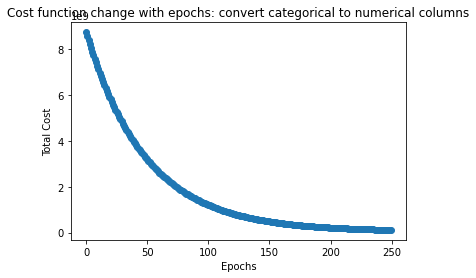

Cost at epoch 0 is: 8755169404.056446
Cost at epoch 25 is: 5319194411.293778
Cost at epoch 50 is: 3253321331.2316866
Cost at epoch 75 is: 2007467973.7357843
Cost at epoch 100 is: 1254725343.4453871
Cost at epoch 125 is: 799367000.066449
Cost at epoch 150 is: 523674446.0274944
Cost at epoch 175 is: 356650252.4115827
Cost at epoch 200 is: 255402237.7541613
Cost at epoch 225 is: 193990108.880682
w = [  9712.86621083   7412.75300792   8503.64771291 -12285.80498169], b = 120389.44268996458


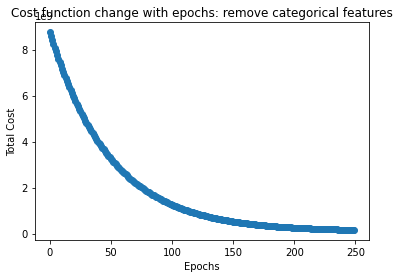

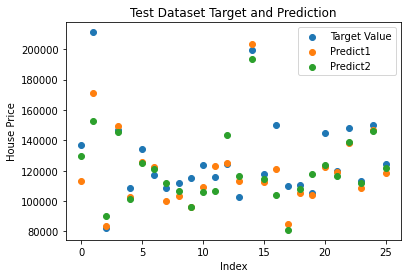

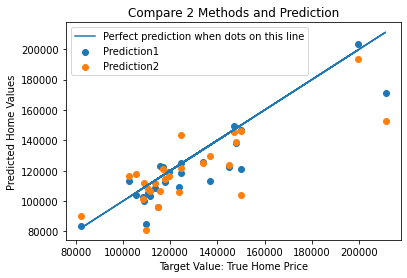

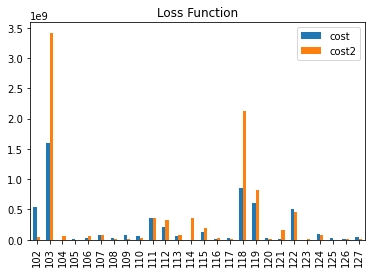

Cost at epoch 0 is: 8761136750.131834
Cost at epoch 25 is: 5421194725.84237
Cost at epoch 50 is: 3393096536.39613
Cost at epoch 75 is: 2160846721.2590165
Cost at epoch 100 is: 1411705499.4559102
Cost at epoch 125 is: 956005552.9479219
Cost at epoch 150 is: 678648242.486068
Cost at epoch 175 is: 509744042.13994384
Cost at epoch 200 is: 406829638.9852461
Cost at epoch 225 is: 344090103.21363187
w = [11928.45985812], b = 120826.0504350959
Cost at epoch 0 is: 8759236155.149208
Cost at epoch 25 is: 5391437938.511452
Cost at epoch 50 is: 3358717367.66901
Cost at epoch 75 is: 2131714238.131132
Cost at epoch 100 is: 1390999980.2969277
Cost at epoch 125 is: 943808555.3306055
Cost at epoch 150 is: 673801788.6969724
Cost at epoch 175 is: 510761497.6627775
Cost at epoch 200 is: 412302581.9649072
Cost at epoch 225 is: 352838369.186363
w = [12945.21590434], b = 120164.55823546424
Cost at epoch 0 is: 8761172080.88348
Cost at epoch 25 is: 5422184624.5053625
Cost at epoch 50 is: 3394939718.8147507
Cost

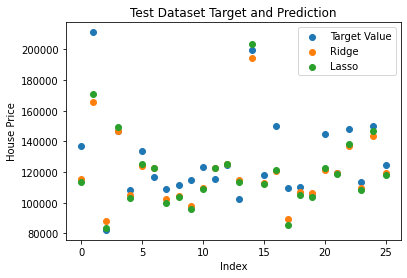

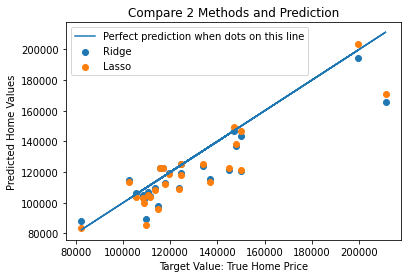

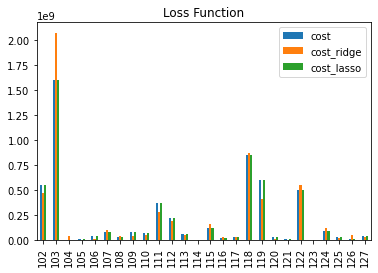

In [6]:
%run hw3_Youyu.ipynb import y_pred2

In [7]:
summary_pred = pd.DataFrame({'Y':y_test,'DecisionTreeRegressor':y_pred_dr,'LinearRegression':y_pred2_test})
summary_pred.head()

,Y,DecisionTreeRegressor,LinearRegression
102,136800,136942.857143,129633.522960
103,211200,179250.000000,152735.525369
104,82300,104792.307692,90281.368596
105,146900,176800.000000,145272.428259
106,108500,118957.142857,101037.583629


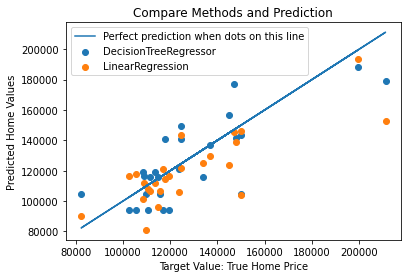

In [8]:
plt.scatter(summary_pred['Y'], summary_pred['DecisionTreeRegressor'], label='DecisionTreeRegressor')
plt.scatter(summary_pred['Y'], summary_pred['LinearRegression'], label='LinearRegression')
plt.plot(summary_pred['Y'], summary_pred['Y'], label='Perfect prediction when dots on this line')
plt.legend(loc="upper left")
plt.title('Compare Methods and Prediction')
plt.xlabel('Target Value: True Home Price')
plt.ylabel('Predicted Home Values')
plt.show()


The plot above indicated that both methods works approximately on the prediction. 

The RMSE and R2 values below indicated better performance for decision tree regressor. However, decision regressor provided outputs with discrete-like result for continuous target value. 

The R2 score indicated that both method did not fit very linearly. The predicted results were a little off from the true values.

In [9]:
cost_dr = (y_test-y_pred_dr)**2
cost_lr = (y_test-y_pred2_test)**2

rmse_dr = np.sqrt(sum(cost_dr)/len(cost_dr))
rmse_lr = np.sqrt(sum(cost_lr)/len(cost_lr))
r2_dr = 1-sum(cost_dr)/sum((y_test-sum(y_test)/len(y_test))**2)
r2_lr = 1-sum(cost_lr)/sum((y_test-sum(y_test)/len(y_test))**2)

rmse_r2_eq = pd.DataFrame({'Method':['DecisionTreeRegressor','LinearRegression'],
                            'RMSE':[rmse_dr,rmse_lr],
                           'R2 score':[r2_dr,r2_lr]})
rmse_r2_eq

,Method,RMSE,R2 score
0,DecisionTreeRegressor,18233.155316,0.566352
1,LinearRegression,18370.297220,0.559804


 d) Do you see any overfitting? How to overcome the overfitting issues? 

After predict on the training dataset, the result showed that decision tree regressor did not predict 100% correct, but the RMSE and R2 is obviously better than the testing dataset. So we can say overfitting issue existed.

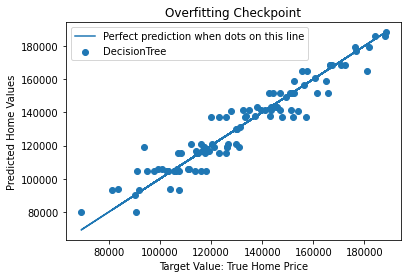

,Method,RMSE,R2 score
0,Test Dataset,18233.155316,0.566352
1,Trained Dataset,7733.322945,0.914784


In [10]:
y_pred_train = regressor.predict(np.array(x_train))
summary_train = pd.DataFrame({'Train':y_train,'Predict':y_pred_train})

plt.scatter(summary_train['Train'], summary_train['Predict'], label='DecisionTree')
plt.plot(summary_train['Train'], summary_train['Train'], label='Perfect prediction when dots on this line')
plt.legend(loc="upper left")
plt.title('Overfitting Checkpoint')
plt.xlabel('Target Value: True Home Price')
plt.ylabel('Predicted Home Values')
plt.show()

cost_dr = (y_test-y_pred_dr)**2
cost_dr_train = (y_train-y_pred_train)**2

rmse_dr = np.sqrt(sum(cost_dr)/len(cost_dr))
rmse_dr_train = np.sqrt(sum(cost_dr_train)/len(cost_dr_train))
r2_dr = 1-sum(cost_dr)/sum((y_test-sum(y_test)/len(y_test))**2)
r2_dr_train = 1-sum(cost_dr_train)/sum((y_train-sum(y_train)/len(y_train))**2)

rmse_r2 = pd.DataFrame({'Method':['Test Dataset','Trained Dataset'],
                            'RMSE':[rmse_dr,rmse_dr_train],
                           'R2 score':[r2_dr,r2_dr_train]})
rmse_r2

#### Classify homework 4 dataset with the decision tree model(17 points)

 a) Fit the decision tree model with RINGS as a response variable. How is the model performance? How do you interpret the model?

In [68]:
filepath = "abalone.data"
col = ["Sex","Length","Diameter","Height","Whole","Shuck","Viscera","Shell","Rings"]
data = pd.read_csv(filepath, delimiter=",",names=col)
data['Age'] = data['Rings']+1.5

age_mean = data['Age'].mean()
age_std = data['Age'].std()
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Add classification and corresponding color for later process.
data['Class'] = "A1"
data['Color'] = color[0]
data['Class'][(data['Age']>=age_mean-2*age_std)&(data['Age']<age_mean-age_std)] = "A2"
data['Color'][(data['Age']>=age_mean-2*age_std)&(data['Age']<age_mean-age_std)] = color[1]
data['Class'][(data['Age']>=age_mean-age_std)&(data['Age']<age_mean)] = "A3"
data['Color'][(data['Age']>=age_mean-age_std)&(data['Age']<age_mean)] = color[2]
data['Class'][(data['Age']>=age_mean)&(data['Age']<age_mean+age_std)] = "A4"
data['Color'][(data['Age']>=age_mean)&(data['Age']<age_mean+age_std)] = color[3]
data['Class'][(data['Age']>=age_mean+age_std)&(data['Age']<age_mean+2*age_std)] = "A5"
data['Color'][(data['Age']>=age_mean+age_std)&(data['Age']<age_mean+2*age_std)] = color[4]
data['Class'][(data['Age']>=age_mean+2*age_std)] = "A6"
data['Color'][(data['Age']>=age_mean+2*age_std)] = color[5]

# Convert column sex as a numerical variable.
data['Sex'][data['Sex']=='M'] = 1
data['Sex'][data['Sex']=='F'] = 2
data['Sex'][data['Sex']=='I'] = 0

C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/3633386854.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Class'][(data['Age']>=age_mean-2*age_std)&(data['Age']<age_mean-age_std)] = "A2"
C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/3633386854.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Color'][(data['Age']>=age_mean-2*age_std)&(data['Age']<age_mean-age_std)] = color[1]
C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/3633386854.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [29]:
train_length = round(data.shape[0]*0.8)
df_train = data.loc[0:train_length-1]
df_test = data.loc[train_length:]

x_train_ring = df_train.drop(['Rings','Age','Class','Color'], axis=1).to_numpy()
y_train_ring = df_train['Rings']

x_test_ring = df_test.drop(['Rings','Age','Class','Color'], axis=1).to_numpy()
y_test_ring = df_test['Rings']

In [116]:
classification = DecisionTree(min_samples_split=2, max_depth=4)
classification.fit_(x_train_ring,y_train_ring)

c:\Users\youyu\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


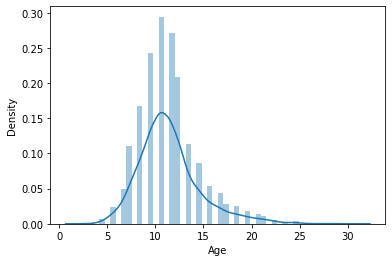

C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/3549557492.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Class'][(data['Age']>=age_mean-2*age_std)&(data['Age']<age_mean-age_std)] = "A2"
C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/3549557492.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Color'][(data['Age']>=age_mean-2*age_std)&(data['Age']<age_mean-age_std)] = color[1]
C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/3549557492.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

 Training Accuray at 0 iterations is 0.5101735487731897
 Training Accuray at 1000 iterations is 0.5215439856373429
 Training Accuray at 2000 iterations is 0.5448833034111311
 Training Accuray at 3000 iterations is 0.5508677438659485
 Training Accuray at 4000 iterations is 0.5571514063435069


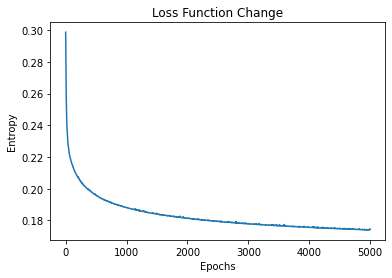

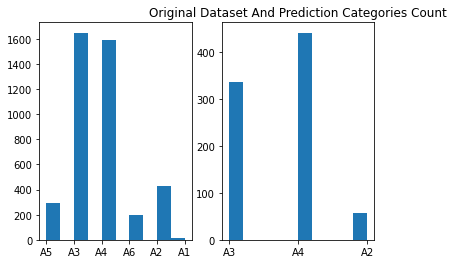

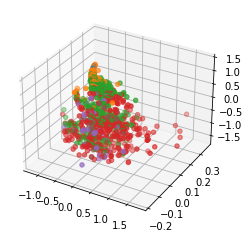

 Training Accuray at 0 iterations is 0.5083782166367444
 Training Accuray at 1000 iterations is 0.5239377618192699
 Training Accuray at 2000 iterations is 0.5532615200478755
 Training Accuray at 3000 iterations is 0.5535607420706165
 Training Accuray at 4000 iterations is 0.5583482944344704


In [21]:
%run hw4_Youyu.ipynb

In [118]:
classification.print_tree()
y_pred_cl = classification.predict(np.array(x_test_ring))
pd.DataFrame({'TestRing':y_test_ring,'PredictRing':y_pred_cl})

X_7 <= 0.144 ? 0.031178994081755396
 left:X_7 <= 0.0385 ? 0.03822202979814526
  left:X_7 <= 0.0215 ? 0.06032001918129348
    left:X_5 <= 0.007 ? 0.04254125941355558
        left:X_3 <= 0.02 ? 0.14351851851851855
                left:4
                right:3
        right:X_1 <= 0.24 ? 0.04404208465867365
                left:5
                right:4
    right:X_1 <= 0.245 ? 0.026826715912588672
        left:X_3 <= 0.06 ? 0.48
                left:4
                right:6
        right:X_4 <= 0.073 ? 0.025374001452432737
                left:5
                right:5
  right:X_0 <= 0 ? 0.021008511338885594
    left:X_7 <= 0.0715 ? 0.016340493649827703
        left:X_6 <= 0.033 ? 0.020822665889847825
                left:6
                right:7
        right:X_7 <= 0.1195 ? 0.01379781199795882
                left:7
                right:8
    right:X_7 <= 0.055 ? 0.01612718863145346
        left:X_5 <= 0.0655 ? 0.0997041420118342
                left:7
                right:6
     

,TestRing,PredictRing
3342,14,9
3343,13,9
3344,13,8
3345,12,12
3346,14,8
...,...,...
4172,11,12
4173,10,10
4174,9,9
4175,10,9


In [33]:
lr1 = LogisticRegression(epochs=5000)
lr1.train(x_train_ring,y_train_ring)

 Training Accuray at 0 iterations is 0.14661879114302812
 Training Accuray at 1000 iterations is 0.2232196289646918
 Training Accuray at 2000 iterations is 0.2277079593058049
 Training Accuray at 3000 iterations is 0.2256134051466188
 Training Accuray at 4000 iterations is 0.234590065828845


In [119]:
y_pred_test = lr1.predict_(np.insert(x_test_ring, 0, 1, axis=1))
y_pred_test = category_pointer(y_cat=y_train_ring,y_pred=y_pred_test)

The prediction above indicate that decision tree classification worked better on extreme cases, and logistic regression tend to predict the most probable cases.

The following metrics calculation use 'Ring' as a target variable. 

Compare the prediction of Ring from both logistic regression and decision tree classifier. 

As the target varibale is a list of discrete number, the outcome of logistic regression is also discrete.

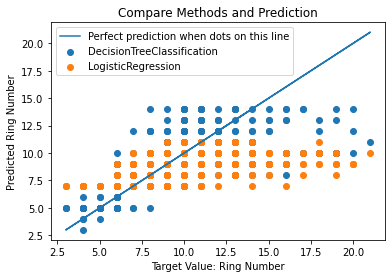

,Method,RMSE,R2 score
0,DecisionTreeClassification,2.083008,0.400436
1,LogisticRegression,2.373759,0.221378


In [120]:
summary_p = pd.DataFrame({'Y':y_test_ring,
                          'DecisionTreePredict':y_pred_cl,
                          'LogisticRegressionPredict':y_pred_test})
plt.scatter(summary_p['Y'], summary_p['DecisionTreePredict'], label='DecisionTreeClassification')
plt.scatter(summary_p['Y'], summary_p['LogisticRegressionPredict'], label='LogisticRegression')
plt.plot(summary_p['Y'], summary_p['Y'], label='Perfect prediction when dots on this line')
plt.legend(loc="upper left")
plt.title('Compare Methods and Prediction')
plt.xlabel('Target Value: Ring Number')
plt.ylabel('Predicted Ring Number')
plt.show()

cost_cl = (y_test_ring-y_pred_cl)**2
cost_lo = (y_test_ring-y_pred_test)**2

rmse_cl = np.sqrt(sum(cost_cl)/len(cost_cl))
rmse_lo = np.sqrt(sum(cost_lo)/len(cost_lo))
r2_cl = 1-sum(cost_cl)/sum((y_test_ring-sum(y_test_ring)/len(y_test_ring))**2)
r2_lo = 1-sum(cost_lo)/sum((y_test_ring-sum(y_test_ring)/len(y_test_ring))**2)

rmse_r2 = pd.DataFrame({'Method':['DecisionTreeClassification','LogisticRegression'],
                        'RMSE':[rmse_cl,rmse_lo],
                        'R2 score':[r2_cl,r2_lo]})
rmse_r2

b) Fit the decision tree with the custom response variable which you created in homework 4. Compare the model performance against logistic regression model (Only performance metrics are fine. Do not need to repeat the code)? Do you find any interesting insights on decision tree model? Which model do you choose for this dataset?


The following part use predicted ring to make classification from A1 to A6, and then compare the classification accuracy with confusion matrix. Since logistic regression did not reach to extreme cases, decision tree classification made better prediction on extreme cases (i.e., A1 and A6), while it give poorer performance on A3 classification.

In [124]:
pred_cl = pd.DataFrame({'TestRing':y_test_ring,'TestAge':y_test_ring+1.5,
                        'DecisionTreeAge':np.array(y_pred_cl)+1.5,
                        'LogisticRegressionAge':np.array(y_pred_test)+1.5})
age_mean = data['Age'].mean()
age_std = data['Age'].std()

# # Add classification and corresponding color for later process.
pred_cl['TestClass'] = "A1"
pred_cl['DTClass'] = "A1"
pred_cl['LRClass'] = "A1"

pred_cl['TestClass'][(pred_cl['TestAge']>=age_mean-2*age_std)&(pred_cl['TestAge']<age_mean-age_std)] = "A2"
pred_cl['DTClass'][(pred_cl['DecisionTreeAge']>=age_mean-2*age_std)&(pred_cl['DecisionTreeAge']<age_mean-age_std)] = "A2"
pred_cl['LRClass'][(pred_cl['LogisticRegressionAge']>=age_mean-2*age_std)&(pred_cl['LogisticRegressionAge']<age_mean-age_std)] = "A2"

pred_cl['TestClass'][(pred_cl['TestAge']>=age_mean-age_std)&(pred_cl['TestAge']<age_mean)] = "A3"
pred_cl['DTClass'][(pred_cl['DecisionTreeAge']>=age_mean-age_std)&(pred_cl['DecisionTreeAge']<age_mean)] = "A3"
pred_cl['LRClass'][(pred_cl['LogisticRegressionAge']>=age_mean-age_std)&(pred_cl['LogisticRegressionAge']<age_mean)] = "A3"

pred_cl['TestClass'][(pred_cl['TestAge']>=age_mean)&(pred_cl['TestAge']<age_mean+age_std)] = "A4"
pred_cl['DTClass'][(pred_cl['DecisionTreeAge']>=age_mean)&(pred_cl['DecisionTreeAge']<age_mean+age_std)] = "A4"
pred_cl['LRClass'][(pred_cl['LogisticRegressionAge']>=age_mean)&(pred_cl['LogisticRegressionAge']<age_mean+age_std)] = "A4"

pred_cl['TestClass'][(pred_cl['TestAge']>=age_mean+age_std)&(pred_cl['TestAge']<age_mean+2*age_std)] = "A5"
pred_cl['DTClass'][(pred_cl['DecisionTreeAge']>=age_mean+age_std)&(pred_cl['DecisionTreeAge']<age_mean+2*age_std)] = "A5"
pred_cl['LRClass'][(pred_cl['LogisticRegressionAge']>=age_mean+age_std)&(pred_cl['LogisticRegressionAge']<age_mean+2*age_std)] = "A5"

pred_cl['TestClass'][(pred_cl['TestAge']>=age_mean+2*age_std)] = "A6"
pred_cl['DTClass'][(pred_cl['DecisionTreeAge']>=age_mean+2*age_std)] = "A6"
pred_cl['LRClass'][(pred_cl['LogisticRegressionAge']>=age_mean+2*age_std)] = "A6"

pred_cl

C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/2245720472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_cl['TestClass'][(pred_cl['TestAge']>=age_mean-2*age_std)&(pred_cl['TestAge']<age_mean-age_std)] = "A2"
C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/2245720472.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_cl['DTClass'][(pred_cl['DecisionTreeAge']>=age_mean-2*age_std)&(pred_cl['DecisionTreeAge']<age_mean-age_std)] = "A2"
C:\Users\youyu\AppData\Local\Temp/ipykernel_25652/2245720472.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

,TestRing,TestAge,DecisionTreeAge,LogisticRegressionAge,TestClass,DTClass,LRClass
3342,14,15.5,10.5,9.5,A5,A3,A3
3343,13,14.5,10.5,10.5,A4,A3,A3
3344,13,14.5,9.5,9.5,A4,A3,A3
3345,12,13.5,13.5,10.5,A4,A4,A3
3346,14,15.5,9.5,8.5,A5,A3,A3
...,...,...,...,...,...,...,...
4172,11,12.5,13.5,10.5,A4,A4,A3
4173,10,11.5,11.5,10.5,A4,A4,A3
4174,9,10.5,10.5,11.5,A3,A3,A4
4175,10,11.5,10.5,11.5,A4,A3,A4


In [125]:
from sklearn.metrics import confusion_matrix

# Logistic Regression Accuracy
confusion_matrix(pred_cl['TestClass'],pred_cl['LRClass'])

array([[  0,   0,   3,   0,   0,   0],
       [  0,   0,  92,   0,   0,   0],
       [  0,   0, 288,  61,   0,   0],
       [  0,   0, 149, 187,   0,   0],
       [  0,   0,  21,  15,   0,   0],
       [  0,   0,  12,   7,   0,   0]], dtype=int64)

In [126]:
# Decision Tree Accuracy
confusion_matrix(pred_cl['TestClass'],pred_cl['DTClass'])

array([[  0,   3,   0,   0,   0,   0],
       [  1,  39,  51,   1,   0,   0],
       [  0,   3, 282,  62,   2,   0],
       [  0,   0, 134, 186,  16,   0],
       [  0,   0,  14,  18,   4,   0],
       [  0,   0,   0,  15,   4,   0]], dtype=int64)

Comparing the confusion matrix, we can conclude that the decision tree classification had better performance on extreme cases prediction (i.e., A2 and A5 prediction), and a little bit lower accuracy on the most probable cases (A3 and A4). If the test dataset has a lot of most probable cases (A3 and A4), logistic regression can be used. Otherwise, decision tree can be more accurate. 

In this case, decision tree provided better prediction result on the testing dataset.

c) If you would like to improve the performance of the decision tree using this model, what steps do you recommend?

In order to improve the performance of the model, I would try different hyperparameters and compare the result using testing dataset with accuracy as a reference metric.


d) What hyperparameters can you use for model optimization in the decision tree?

The tree depth and minimum split sample are the adjustable hyperparameters.

e) How do you control the depth of the decision tree in your custom model?

The depth of decision tree should both fit the training dataset and give a good prediction on test dataset. If depth is too large, the tree might grow too far and overfitting. If the depth is too small, the model would be too rough to give an accurate prediction.

Comparing the prediction of both training and testing dataset, we can know if overfitting exists. If the accuracy of training dataset prediction is obviously higher than the testing dataset, then we can say the model will overfit, and we can prune the decision tree with lower maximum depth setup. 